In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np

!nvidia-smi
import os
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ['CUDA_VISIBLE_DEVICES'] = '2'
import torch
print(torch.cuda.get_device_name())


In [3]:
import numpy

import cupy
from cupy import cublas
from cupy import cusparse
from cupy.cuda import cusolver
from cupy.cuda import device
from cupy.cuda import runtime
from cupy.linalg import _util
import cupyx
from cupyx.scipy import sparse
from cupyx.scipy.sparse.linalg import _interface
from cupyx.scipy.sparse.linalg._iterative import _make_system
import nibabel as nib

import cupy as cp
def cupyCG(A2,b2):
    #print(b2.shape,b2.dtype,b2.device)
    b_val = cp.asarray(b2.data)
    n1 = len(b_val)
    A_ind = cp.asarray(A2._indices().data)
    A_val = cp.asarray(A2._values().data)
    SC = cupyx.scipy.sparse.csr_matrix((A_val,(A_ind[0,:],A_ind[1,:])), shape=(n1,n1))
    solution = cupyx.scipy.sparse.linalg.cg(SC, b_val,tol=1e-3,maxiter=40)[0]#.get()#
    x = torch.as_tensor(solution, device='cuda')
    return x


def dice_coeff(outputs, labels, max_label):
    dice = torch.FloatTensor(max_label-1).fill_(0)
    for label_num in range(1, max_label):
        iflat = (outputs==label_num).view(-1).float()
        tflat = (labels==label_num).view(-1).float()
        intersection = torch.mean(iflat * tflat)
        dice[label_num-1] = (2. * intersection) / (1e-8 + torch.mean(iflat) + torch.mean(tflat))
    return dice


In [15]:
edt_val = torch.zeros(10,192,160,256)
for i,nu in enumerate((1,4,7,10,23,26,29,32,35,38)):
    nnunet = torch.from_numpy(nib.load('l2r_abdomen_ctct/validation_post/img00'+str(nu).zfill(2)+'.nii.gz').get_fdata())#.float().cuda()
    edt_val[i] = torch.from_numpy(edt(nnunet>0)).float().sqrt()-torch.from_numpy(edt(nnunet==0)).float().sqrt()


#edt_val = torch.load('edt_val.pth')
gt_val = torch.zeros(10,192,160,256)
for i,nu in enumerate((1,4,7,10,23,26,29,32,35,38)):
    gt_val[i] = torch.from_numpy(nib.load('l2r_abdomen_ctct/Training/label/label00'+str(nu).zfill(2)+'.nii.gz').get_fdata())#.float().cuda()



#test_edt = test_edt.unsqueeze(0).unsqueeze(0)
label_fix = F.one_hot(gt_val[-3].squeeze().long(),14).permute(3,0,1,2).unsqueeze(0).float()
label_moving = F.one_hot(gt_val[-1].squeeze().long(),14).permute(3,0,1,2).unsqueeze(0).float()

print('lfix',label_fix.shape)
edt_fix = edt_val[-3].float()
edt_mov = edt_val[-1].float()
fixed = (edt_fix*20+0*torch.randn_like(edt_fix)).cuda().unsqueeze(0).unsqueeze(0)
moving = (edt_mov*20+0*torch.randn_like(edt_fix)).cuda().unsqueeze(0).unsqueeze(0)


H,W,D = label_fix.shape[-3:]

lfix torch.Size([1, 14, 192, 160, 256])


In [27]:
idx_all = torch.empty(0,2).long()
for i in range(10):
    for j in range(10):
        if(i<j):
            idx_all = torch.cat((idx_all,torch.tensor([i,j]).long().view(1,2)),0)
print(len(idx_all))

45


In [12]:
def laplaceMatrix(H,W,D,lambda_weight = 500):
    
    xy = torch.arange(H*W*D).cuda().view(H,W,D);
    i1 = torch.cat((xy[1:].reshape(1,-1),xy[:-1].reshape(1,-1)),0)
    i2 = torch.cat((xy[:-1].reshape(1,-1),xy[1:].reshape(1,-1)),0)
    i3 = torch.cat((xy[:,1:].reshape(1,-1),xy[:,:-1].reshape(1,-1)),0)
    i4 = torch.cat((xy[:,:-1].reshape(1,-1),xy[:,1:].reshape(1,-1)),0)
    i5 = torch.cat((xy[:,:,1:].reshape(1,-1),xy[:,:,:-1].reshape(1,-1)),0)
    i6 = torch.cat((xy[:,:,:-1].reshape(1,-1),xy[:,:,1:].reshape(1,-1)),0)


    idx = torch.cat((i1,i2,i3,i4,i5,i6),1)

    #lambda_weight = 5000#1250
    val = torch.ones(idx.shape[1]).cuda()#2*(2*H*W-H-W))

    A = torch.sparse.FloatTensor(idx,-lambda_weight*val,(H*W*D,H*W*D))
    D1 = -torch.sparse.sum(A,0).to_dense()
    D = torch.sparse.FloatTensor(torch.cat((xy.view(1,-1),xy.view(1,-1)),0),D1,(H*W*D,H*W*D))
        
    return D+A

/opt/tljh/user/lib/python3.9/site-packages/torch/nn/functional.py:4065: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  warnings.warn(
/opt/tljh/user/lib/python3.9/site-packages/torch/nn/functional.py:4003: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  warnings.warn(


time total 3.2775204181671143 dice tensor(0.5236)
tensor([0.5275, 0.7548, 0.7267, 0.0000, 0.6979, 0.8895, 0.5208, 0.8104, 0.6677,
        0.2200, 0.1941, 0.4052, 0.3922]) tensor(0.5236)


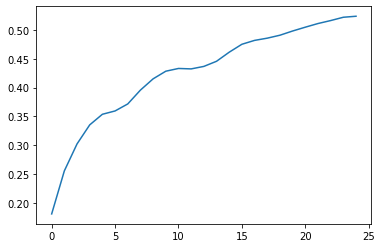

In [29]:
def adamReg(edt_fix,edt_mov,label_fix,label_mov):

    #disp_hr = dense_flow#F.interpolate(dense_flow,size=(H,W,D),mode='trilinear',align_corners=False)
    grid_sp = 4
    mind_fix = .2*F.avg_pool3d(F.avg_pool3d(edt_fix.cuda().unsqueeze(0).unsqueeze(0),2),2)
    mind_mov = .2*F.avg_pool3d(F.avg_pool3d(edt_mov.cuda().unsqueeze(0).unsqueeze(0),2),2)

    #disp_lr = F.interpolate(disp_hr,size=(H//grid_sp,W//grid_sp,D//grid_sp),mode='trilinear',align_corners=False)
    net = nn.Sequential(nn.Conv3d(3,1,(H//grid_sp,W//grid_sp,D//grid_sp),bias=False))
    net[0].weight.data[:] = 0.00#disp_lr.float().cpu().data/grid_sp
    net.cuda()
    optimizer = torch.optim.Adam(net.parameters(), lr=1)#,=.5)
    grid0 = F.affine_grid(torch.eye(3,4).unsqueeze(0).cuda(),(1,1,H//grid_sp,W//grid_sp,D//grid_sp),align_corners=False)
    #run Adam optimisation with diffusion regularisation and B-spline smoothing
    lambda_weight = .65# with tps: .5, without:0.7
    run_tre1 = torch.zeros(25)
    t0 = time.time()


    for iter in range(25):#25):#80
        optimizer.zero_grad()
        disp_sample = F.avg_pool3d(F.avg_pool3d(F.avg_pool3d(net[0].weight,3,stride=1,padding=1),3,stride=1,padding=1),3,stride=1,padding=1).permute(0,2,3,4,1)
        reg_loss = lambda_weight*((disp_sample[0,:,1:,:]-disp_sample[0,:,:-1,:])**2).mean()+\
        lambda_weight*((disp_sample[0,1:,:,:]-disp_sample[0,:-1,:,:])**2).mean()+\
        lambda_weight*((disp_sample[0,:,:,1:]-disp_sample[0,:,:,:-1])**2).mean()
        scale = torch.tensor([(H//grid_sp-1)/2,(W//grid_sp-1)/2,(D//grid_sp-1)/2]).cuda().unsqueeze(0)
        grid_disp = grid0.view(-1,3).cuda().float()+((disp_sample.view(-1,3))/scale).flip(1).float()
        patch_mov_sampled = F.grid_sample(mind_mov.float(),grid_disp.view(1,H//grid_sp,W//grid_sp,D//grid_sp,3).cuda(),align_corners=False,mode='bilinear')#,padding_mode='border')
        sampled_cost = (patch_mov_sampled-mind_fix).pow(2).mean(1)*12
        loss = sampled_cost.mean()
        (loss+reg_loss).backward()
        optimizer.step()
        fitted_grid = disp_sample.permute(0,4,1,2,3).detach()
        disp_hr = F.interpolate(fitted_grid*grid_sp,size=(H,W,D),mode='trilinear',align_corners=False)

        disp_smooth = F.avg_pool3d(F.avg_pool3d(F.avg_pool3d(disp_hr,3,padding=1,stride=1),3,padding=1,stride=1),3,padding=1,stride=1)


        disp_hr = torch.flip(disp_smooth/torch.tensor([H-1,W-1,D-1]).view(1,3,1,1,1).cuda()*2,[1])

        warped_seg = F.grid_sample(label_moving.view(1,-1,H,W,D).cuda(),disp_hr.permute(0,2,3,4,1)+F.affine_grid(torch.eye(3,4).cuda().unsqueeze(0),(1,1,H,W,D)))
        d1 = dice_coeff(label_fix.cuda().argmax(1),warped_seg.argmax(1),14).cpu()
        run_tre1[iter] = d1.mean()
        
    print('time total',time.time()-t0,'dice',d1.mean())


    return run_tre1,d1


idx = torch.tensor([6,9]).long()

label_fix = F.one_hot(gt_val[idx[0]].squeeze().long(),14).permute(3,0,1,2).unsqueeze(0).float()
label_moving = F.one_hot(gt_val[idx[1]].squeeze().long(),14).permute(3,0,1,2).unsqueeze(0).float()

edt_fix = edt_val[idx[0]].float()
edt_mov = edt_val[idx[1]].float()

run_tre1,d1 = adamReg(edt_fix,edt_mov,label_fix,label_moving)

print(d1,d1.mean())

plt.plot(torch.arange(25),run_tre1)
plt.show()

In [ ]:
#data.moving#torch.roll(data.fixed,(2,-3),dims=(2,3))
import math
import time


def GaussNewtonReg(fixed,moving,label_fix,label_moving):
    H,W,D = fixed.shape[-3:]

    grid_sp = 4
    net = nn.Conv3d(3,1,(H//grid_sp,W//grid_sp,D//grid_sp),bias=False)
    net.weight.data[:] = 0
    net.cuda()
    print(net.weight.shape)

    optimizer = torch.optim.SGD(net.parameters(), lr=1,momentum=.5)#.75,momentum=.75)

    out = net(torch.zeros(1,3,H//grid_sp,W//grid_sp,D//grid_sp).cuda())
    out.sum().backward()

    optimizer.zero_grad()


    xy = torch.arange(H*W*D//64).cuda().view(H//4,W//4,D//4)
    L = laplaceMatrix(H//4,W//4,D//4,25)
    run_tre2 = torch.zeros(10)

    lambdas = torch.logspace(math.log10(125),math.log10(25),10)
    hw = 0
    t_sparse = 0
    t0 = time.time()
    for iter in range(10):
        L = laplaceMatrix(H//4,W//4,D//4,lambdas[iter])#150)

        update = net.weight.data.clone().detach()

        if(update.grad is not None):
            update.grad.data[:] = 0

        update.requires_grad = True

        grid = F.avg_pool3d(F.avg_pool3d(2*update.div(torch.tensor([D-.5,W-.5,H-.5]).cuda().view(1,3,1,1,1)),hw*2+1,stride=1,padding=hw),hw*2+1,stride=1,padding=hw)\
        +F.affine_grid(torch.eye(3,4).cuda().unsqueeze(0),(1,1,H//4,W//4,D//4),align_corners=False).permute(0,4,1,2,3)


        warped = F.grid_sample(moving,F.interpolate(grid,scale_factor=4,mode='trilinear').permute(0,2,3,4,1),align_corners=False,mode='bilinear',padding_mode='border')

        #warped-fixed
        loss = F.avg_pool3d(F.avg_pool3d(warped-fixed,2),2).sum(1)
        loss.sum().backward()

        #geometric Nesterov gradients (with prior warp) 
        #with torch.no_grad():
        #    grad = F.grid_sample(update.grad,grid.permute(0,2,3,4,1))
        grad = update.grad



        Mxx = torch.sparse.FloatTensor(torch.cat((xy.view(1,-1),xy.view(1,-1)),0),
                                    torch.pow(grad[0,0],2).view(-1),(H*W*D//64,H*W*D//64))
        Myy = torch.sparse.FloatTensor(torch.cat((xy.view(1,-1),xy.view(1,-1)),0),
                                    torch.pow(grad[0,1],2).view(-1),(H*W*D//64,H*W*D//64))
        Mzz = torch.sparse.FloatTensor(torch.cat((xy.view(1,-1),xy.view(1,-1)),0),
                                    torch.pow(grad[0,2],2).view(-1),(H*W*D//64,H*W*D//64))
        bx = -((loss)*grad[:,:1]).view(-1,1) - torch.sparse.mm(L,update[0,0].view(-1,1))
        by = -((loss)*grad[:,1:2]).view(-1,1) - torch.sparse.mm(L,update[0,1].view(-1,1))
        bz = -((loss)*grad[:,2:3]).view(-1,1) - torch.sparse.mm(L,update[0,2].view(-1,1))


        A = L + Mxx
        t0_ = time.time()
        x = cupyCG(A,bx)
        net.weight.grad.data[0,0] = -x.view(1,1,H//4,W//4,D//4)
        A = L + Myy
        x = cupyCG(A,by)
        net.weight.grad.data[0,1] = -x.view(1,1,H//4,W//4,D//4)
        A = L + Mzz
        x = cupyCG(A,bz)
        net.weight.grad.data[0,2] = -x.view(1,1,H//4,W//4,D//4)
        optimizer.step()

        t_sparse += time.time()-t0_

        grid = F.avg_pool3d(F.avg_pool3d(2*update.div(torch.tensor([D-.5,W-.5,H-.5]).cuda().view(1,3,1,1,1)),hw*2+1,stride=1,padding=hw),hw*2+1,stride=1,padding=hw)\
        +F.affine_grid(torch.eye(3,4).cuda().unsqueeze(0),(1,1,H//4,W//4,D//4),align_corners=False).permute(0,4,1,2,3)



        label_warped = F.grid_sample(label_moving.view(1,-1,H,W,D).cuda(),F.interpolate(grid,scale_factor=4,mode='trilinear').permute(0,2,3,4,1))



        d2 = dice_coeff(label_fix.cuda().argmax(1),label_warped.argmax(1),14).cpu()


        run_tre2[iter] = d2.mean()
    print('time total',time.time()-t0,'sparse',t_sparse,'dice',d2.mean())
    return run_tre2,d2
    
d1_all = torch.zeros(45,13)
d2_all = torch.zeros(45,13)
d1_run = torch.zeros(45,25)
d2_run = torch.zeros(45,10)



for i in range(45):
    idx = idx_all[i]
#idx = torch.tensor([6,9]).long()

    label_fix = F.one_hot(gt_val[idx[0]].squeeze().long(),14).permute(3,0,1,2).unsqueeze(0).float()
    label_moving = F.one_hot(gt_val[idx[1]].squeeze().long(),14).permute(3,0,1,2).unsqueeze(0).float()

    edt_fix = edt_val[idx[0]].float()
    edt_mov = edt_val[idx[1]].float()
    fixed = (edt_fix*20+0*torch.randn_like(edt_fix)).cuda().unsqueeze(0).unsqueeze(0)
    moving = (edt_mov*20+0*torch.randn_like(edt_fix)).cuda().unsqueeze(0).unsqueeze(0)

    run_tre1,d1 = adamReg(edt_fix,edt_mov,label_fix,label_moving)
    d1_all[i,:] = d1
    d1_run[i] = run_tre1


    run_tre2,d2 = GaussNewtonReg(fixed,moving,label_fix,label_moving)
    d2_all[i,:] = d2
    d2_run[i] = run_tre2


    

#plt.plot(torch.arange(25),run_tre1)
#plt.plot(torch.arange(10),run_tre2)



#plt.show()

#print(d2,d2.mean())

In [39]:

d_ident = torch.zeros(len(idx_all),13)
for i in range(len(idx_all)):

    ii = idx_all[i]
    ival = ii.div(3).long()


    d0 = dice_coeff(gt_val[ival[:1]].cuda().squeeze().long().contiguous(),gt_val[ival[:1]].cuda().squeeze().long().contiguous(),14)
    d0 *= dice_coeff(gt_val[ival[1:]].cuda().squeeze().long().contiguous(),gt_val[ival[1:]].cuda().squeeze().long().contiguous(),14)
    d_ident[i] = d0


print()

print('Adam',d1_all.mean()/d_ident.mean())

print('GN',d2_all.mean()/d_ident.mean())





Adam tensor(0.5070)
GN tensor(0.5290)


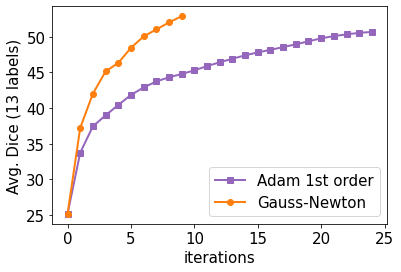

In [46]:
import matplotlib
matplotlib.rcParams.update({'font.size': 15})
plt.plot(torch.arange(25),100*d1_run.mean(0),'s-',color='tab:purple',linewidth=2,label='Adam 1st order')
plt.plot(torch.arange(10),100*d2_run.mean(0),'o-',color='tab:orange',linewidth=2,label='Gauss-Newton')
plt.xlabel('iterations')
plt.ylabel('Avg. Dice (13 labels)')

plt.legend()
plt.savefig('midl2022_short_fig.pdf')
plt.show()